<a href="https://colab.research.google.com/github/Badgujarsiddhi/crop-recommendation-/blob/main/crop_version_with_graphs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PREPROCESSING STARTS HERE

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv('/content/Crop_recommendation.csv')  # Upload the file in Colab
df.head()


,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [3]:
print("Rows:", df.shape[0])
print("Columns:", df.shape[1])


Rows: 2200
Columns: 8


In [4]:
df.dtypes


,0
N,int64
P,int64
K,int64
temperature,float64
humidity,float64
ph,float64
rainfall,float64
label,object


In [5]:
df['label'].nunique(), df['label'].unique()


(22,
 array(['rice', 'maize', 'chickpea', 'kidneybeans', 'pigeonpeas',
        'mothbeans', 'mungbean', 'blackgram', 'lentil', 'pomegranate',
        'banana', 'mango', 'grapes', 'watermelon', 'muskmelon', 'apple',
        'orange', 'papaya', 'coconut', 'cotton', 'jute', 'coffee'],
       dtype=object))

In [6]:
# Summary stats for N, P, K
npk_stats = df[['N', 'P', 'K']].describe().loc[['mean', 'min', 'max', 'std']]
print("Stats for N, P, K:")
print(npk_stats)

# Summary stats for temperature, humidity, ph, rainfall
env_stats = df[['temperature', 'humidity', 'ph', 'rainfall']].describe().loc[['mean', 'min', 'max', 'std']]
print("\nStats for temperature, humidity, ph, rainfall:")
print(env_stats)

Stats for N, P, K:
               N           P           K
mean   50.551818   53.362727   48.149091
min     0.000000    5.000000    5.000000
max   140.000000  145.000000  205.000000
std    36.917334   32.985883   50.647931

Stats for temperature, humidity, ph, rainfall:
      temperature   humidity        ph    rainfall
mean    25.616244  71.481779  6.469480  103.463655
min      8.825675  14.258040  3.504752   20.211267
max     43.675493  99.981876  9.935091  298.560117
std      5.063749  22.263812  0.773938   54.958389


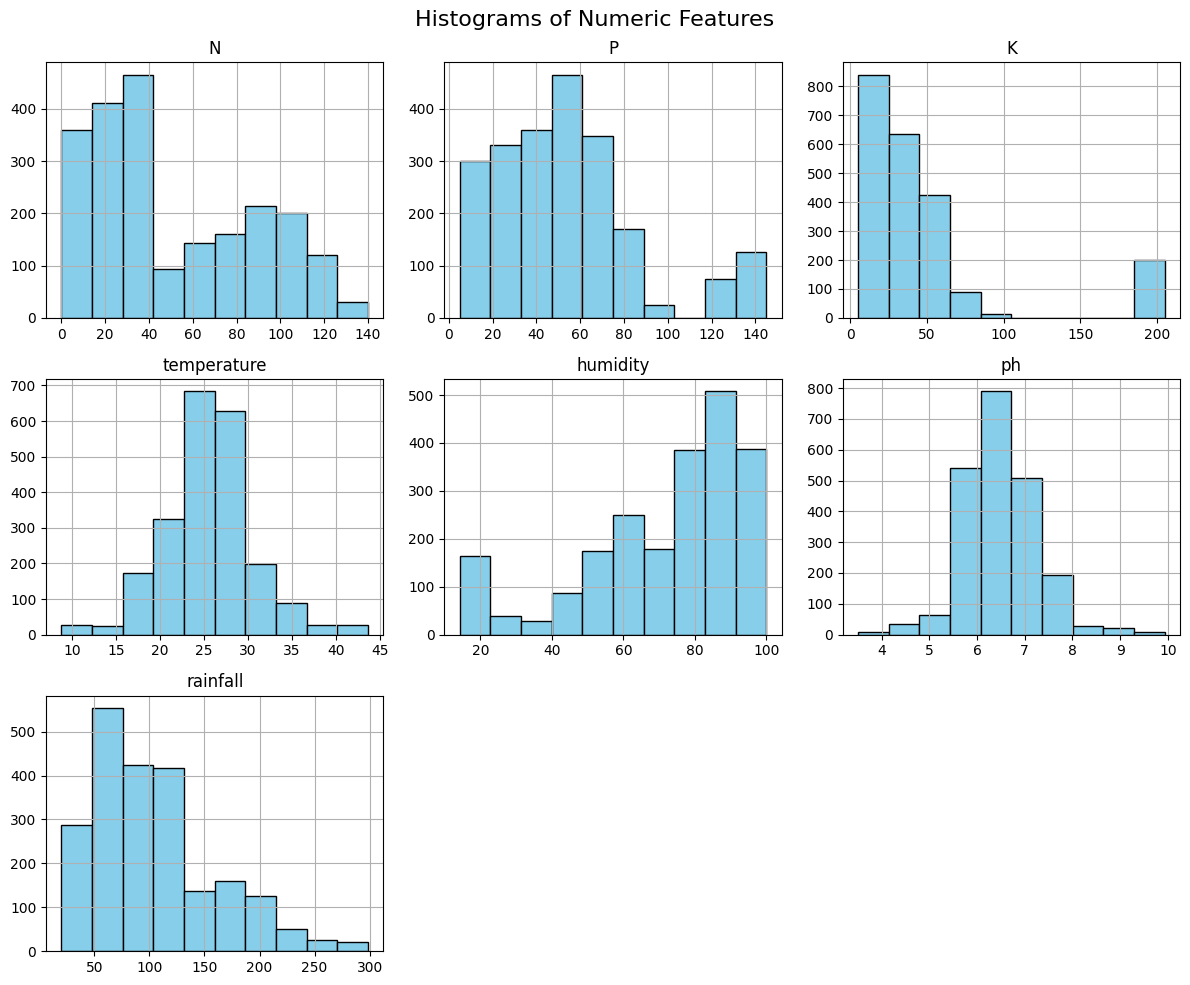

In [7]:
# Plotting histograms for all numeric features
df.hist(figsize=(12, 10), color='skyblue', edgecolor='black')
plt.suptitle('Histograms of Numeric Features', fontsize=16)
plt.tight_layout()
plt.show()

/tmp/ipython-input-2560264720.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=crop_counts.index, x=crop_counts.values, palette='viridis')


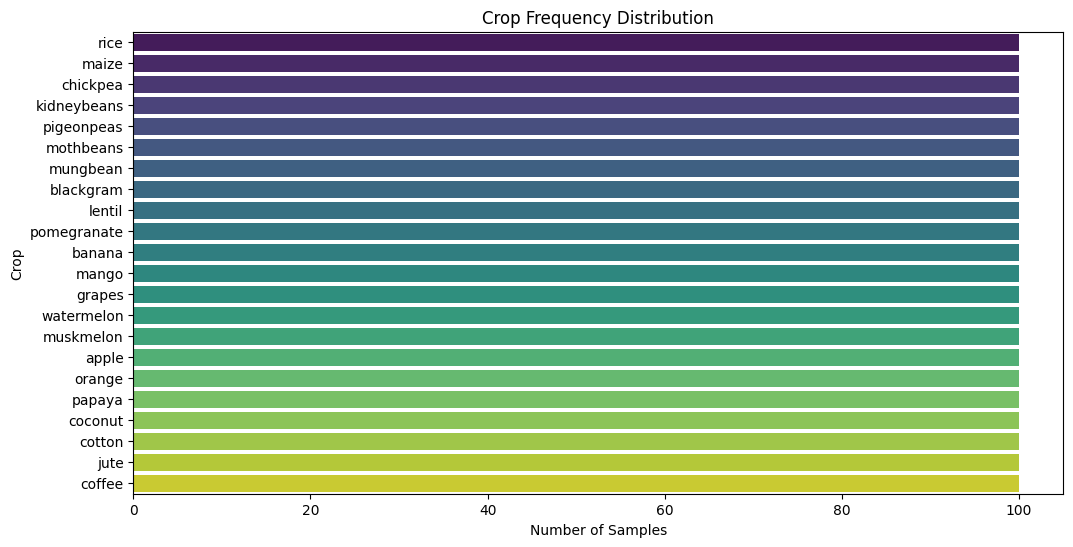

Top 5 Crops:
 label
rice           100
maize          100
chickpea       100
kidneybeans    100
pigeonpeas     100
Name: count, dtype: int64

Bottom 5 Crops:
 label
papaya     100
coconut    100
cotton     100
jute       100
coffee     100
Name: count, dtype: int64


In [8]:
# Count and plot frequency of each crop
crop_counts = df['label'].value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(y=crop_counts.index, x=crop_counts.values, palette='viridis')
plt.title('Crop Frequency Distribution')
plt.xlabel('Number of Samples')
plt.ylabel('Crop')
plt.show()

# Display top and bottom crops (if not all are equal)
print("Top 5 Crops:\n", crop_counts.head())
print("\nBottom 5 Crops:\n", crop_counts.tail())


In [9]:
def detect_outliers_iqr(data, feature):
    Q1 = data[feature].quantile(0.25)
    Q3 = data[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = data[(data[feature] < lower) | (data[feature] > upper)]
    print(f"{feature} → Outliers: {outliers.shape[0]} | Lower: {lower:.2f} | Upper: {upper:.2f}")

for col in ['temperature', 'rainfall', 'ph']:
    detect_outliers_iqr(df, col)


temperature → Outliers: 86 | Lower: 14.08 | Upper: 37.25
rainfall → Outliers: 100 | Lower: -25.02 | Upper: 213.84
ph → Outliers: 57 | Lower: 4.54 | Upper: 8.35


In [10]:
from sklearn.preprocessing import StandardScaler

features = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])
X_scaled = pd.DataFrame(X_scaled, columns=features)
X_scaled.head()


,N,P,K,temperature,humidity,ph,rainfall
0,1.068797,-0.344551,-0.101688,-0.935587,0.472666,0.043302,1.810361
1,0.933329,0.140616,-0.141185,-0.759646,0.397051,0.734873,2.242058
2,0.255986,0.049647,-0.081939,-0.515898,0.486954,1.771510,2.921066
3,0.635298,-0.556811,-0.160933,0.172807,0.389805,0.660308,2.537048
4,0.743673,-0.344551,-0.121436,-1.083647,0.454792,1.497868,2.898373


In [11]:
# Check again
df.isnull().sum(), df.duplicated().sum()


(N              0
 P              0
 K              0
 temperature    0
 humidity       0
 ph             0
 rainfall       0
 label          0
 dtype: int64,
 np.int64(0))

In [12]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])

# View mapping
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label Mapping:\n", label_mapping)
df[['label', 'label_encoded']].head()


Label Mapping:
 {'apple': np.int64(0), 'banana': np.int64(1), 'blackgram': np.int64(2), 'chickpea': np.int64(3), 'coconut': np.int64(4), 'coffee': np.int64(5), 'cotton': np.int64(6), 'grapes': np.int64(7), 'jute': np.int64(8), 'kidneybeans': np.int64(9), 'lentil': np.int64(10), 'maize': np.int64(11), 'mango': np.int64(12), 'mothbeans': np.int64(13), 'mungbean': np.int64(14), 'muskmelon': np.int64(15), 'orange': np.int64(16), 'papaya': np.int64(17), 'pigeonpeas': np.int64(18), 'pomegranate': np.int64(19), 'rice': np.int64(20), 'watermelon': np.int64(21)}


,label,label_encoded
0,rice,20
1,rice,20
2,rice,20
3,rice,20
4,rice,20


In [13]:
df.head()

,N,P,K,temperature,humidity,ph,rainfall,label,label_encoded
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice,20
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice,20
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice,20
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice,20
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice,20


In [14]:
from sklearn.model_selection import train_test_split

X = X_scaled
y = df['label_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)

Training set size: (1760, 7)
Testing set size: (440, 7)


PREPROCESSING ENDS HERE

In [15]:
numeric=X_scaled
numeric.corr()

,N,P,K,temperature,humidity,ph,rainfall
N,1.000000,-0.231460,-0.140512,0.026504,0.190688,0.096683,0.059020
P,-0.231460,1.000000,0.736232,-0.127541,-0.118734,-0.138019,-0.063839
K,-0.140512,0.736232,1.000000,-0.160387,0.190859,-0.169503,-0.053461
temperature,0.026504,-0.127541,-0.160387,1.000000,0.205320,-0.017795,-0.030084
humidity,0.190688,-0.118734,0.190859,0.205320,1.000000,-0.008483,0.094423
ph,0.096683,-0.138019,-0.169503,-0.017795,-0.008483,1.000000,-0.109069
rainfall,0.059020,-0.063839,-0.053461,-0.030084,0.094423,-0.109069,1.000000


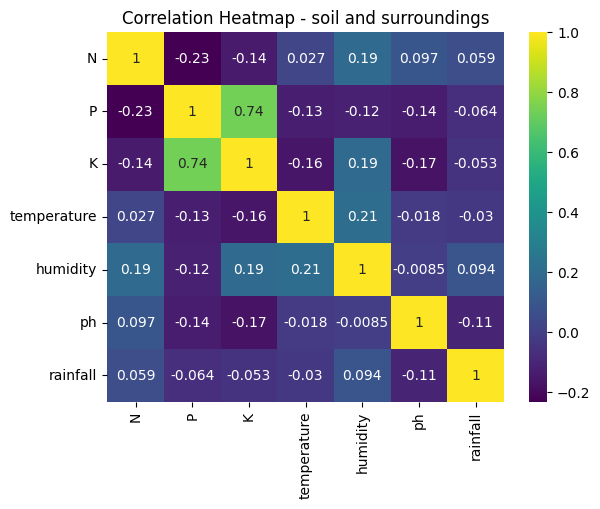

In [16]:
# Correlation heatmap
sns.heatmap(numeric.corr(), annot=True, cmap='viridis')
plt.title("Correlation Heatmap - soil and surroundings")
plt.show()

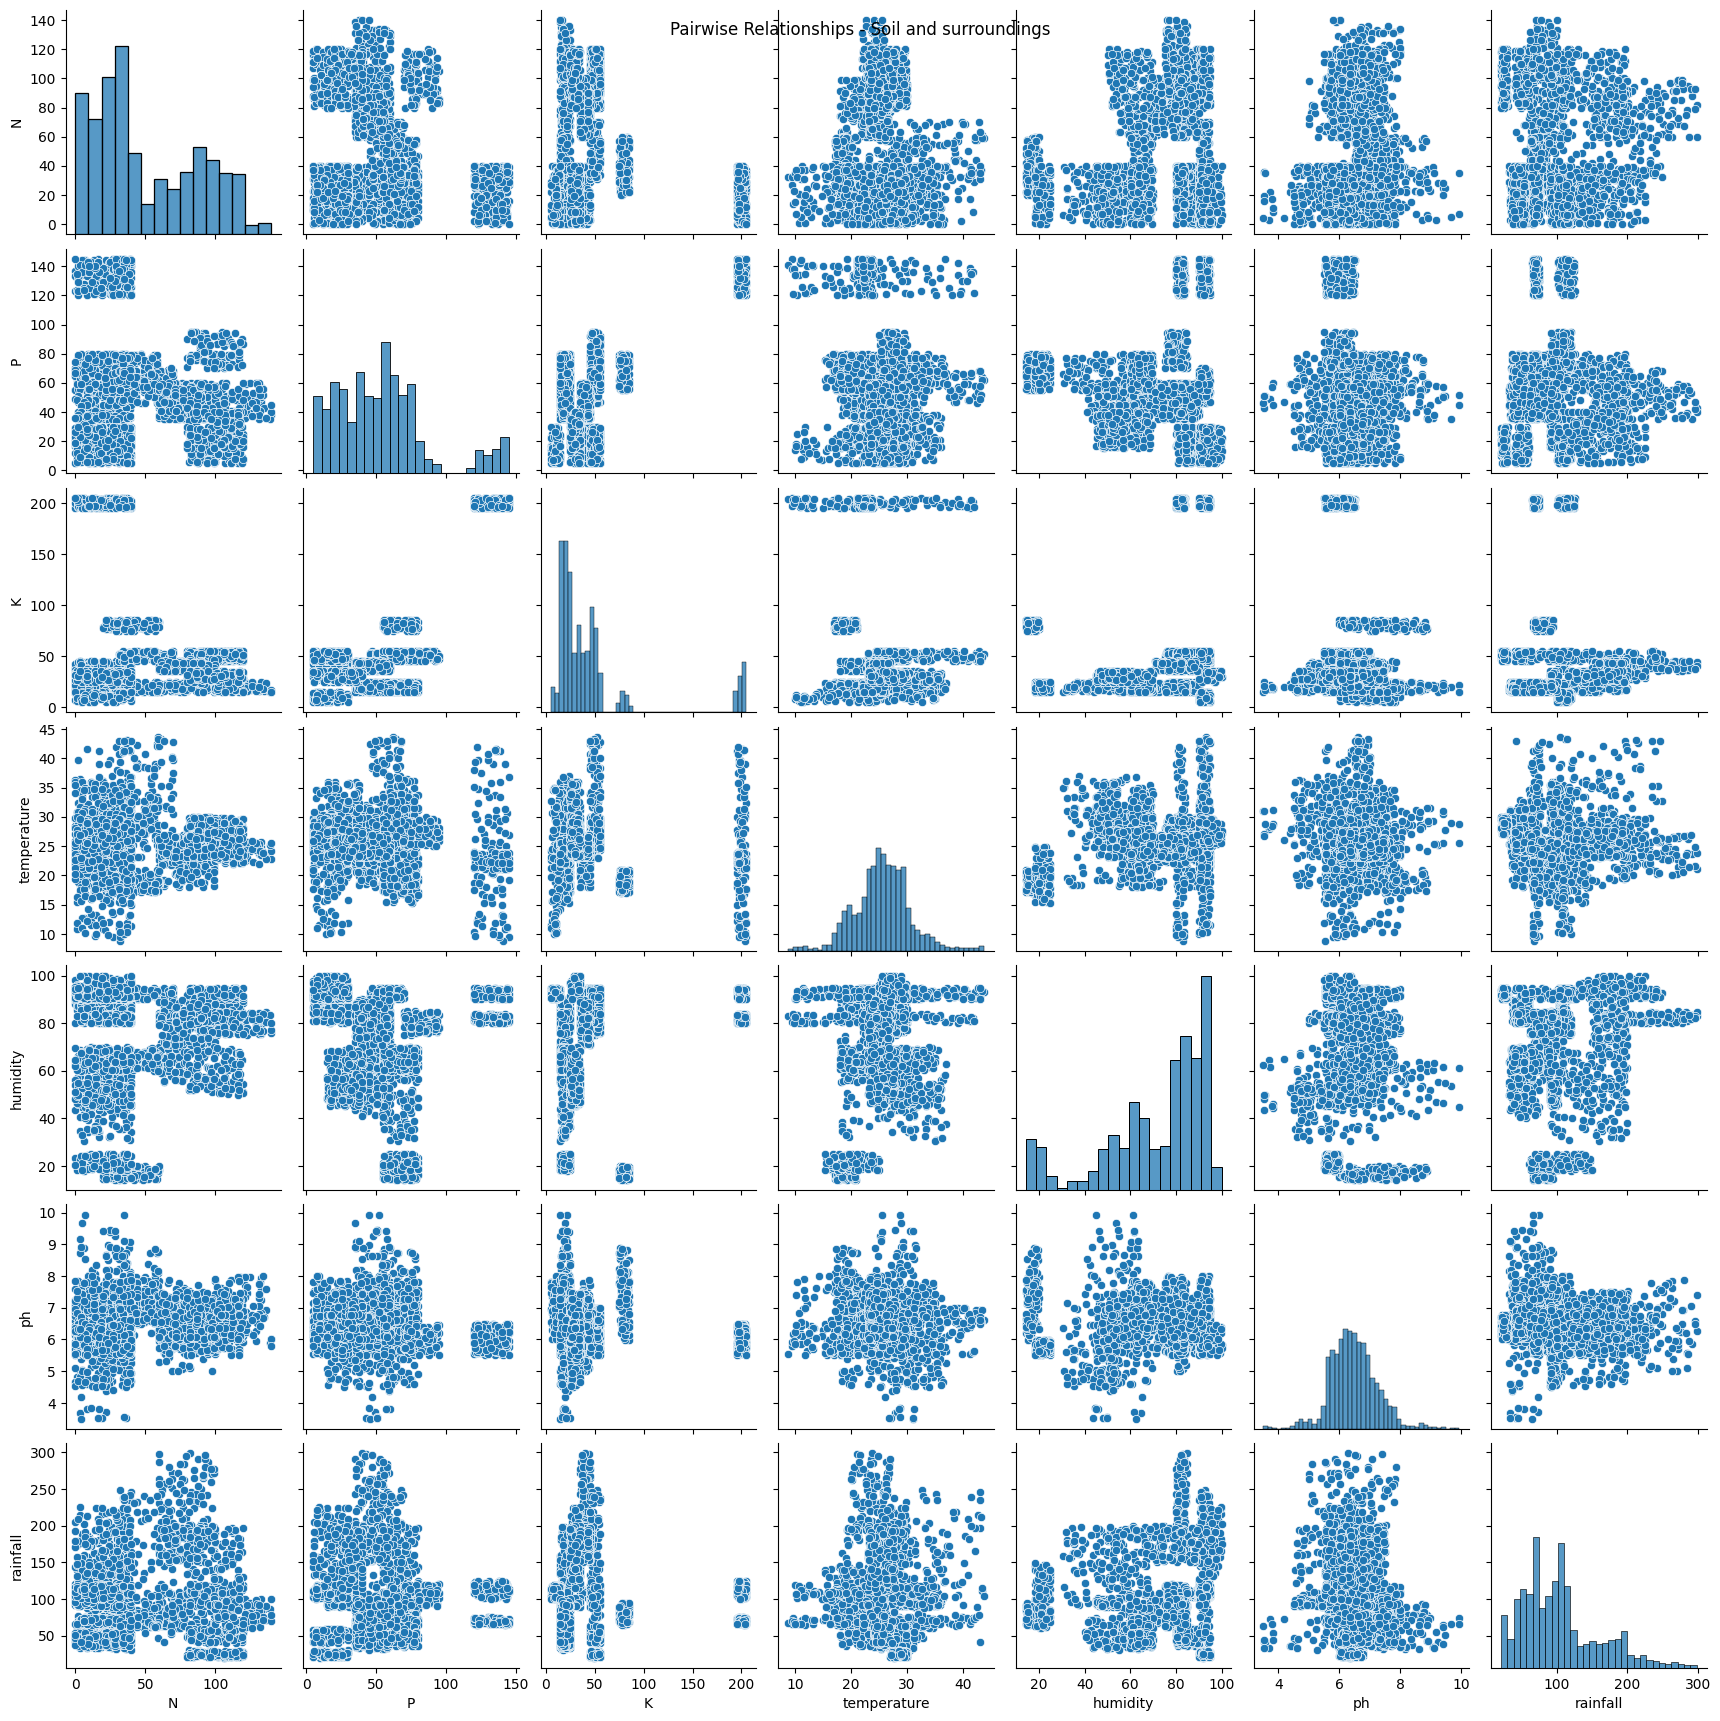

In [17]:
sns.pairplot(df[numeric.columns])
plt.suptitle("Pairwise Relationships - Soil and surroundings")
plt.show()

# MODEL FITTING

Applying Logistic Regression

In [18]:
# initializing the model

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [19]:
# making predictions on testing data

y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[23  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 21  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 19  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 26  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 27  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0 20  0  0  0  0  0  0  0  0  1  0  0  1  0]
 [ 0  0  0  0  0  0  0  0  0 19  0  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 11  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0 20  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 19  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0 22  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0

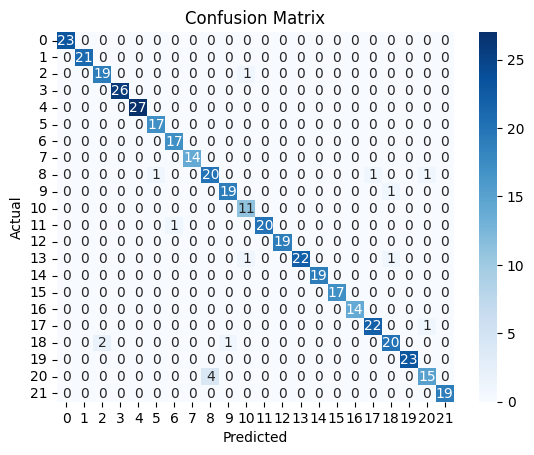

In [20]:
# plot confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [21]:
# find accuracy of testing
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))

Accuracy: 0.9636363636363636
Precision: 0.9644420567548909
Recall: 0.9636363636363636
F1 Score: 0.9635115059268677




```
# This is formatted as code
```

Applying clustering(optional) :

In [22]:
# # plot clusters
# plt.figure(figsize=(8, 6))
# plt.scatter(df['temperature'], df['humidity'], c=df['cluster'])
# plt.xlabel('temperature')
# plt.ylabel('humidity')
# plt.title('K-Means Clustering temperature vs humidity)')
# plt.grid(True)
# plt.show()

In [23]:
# # initializing kmeans
# k = 3
# kmeans = KMeans(n_clusters=k, random_state=42)
# df['cluster'] = kmeans.fit_predict(X)

In [24]:
# print(kmeans.inertia_)

In [25]:
# # Find optimal number of clusters
# inertias = []
# k_range = range(1, 20)

# for k in k_range:
#     km = KMeans(n_clusters=k, random_state=42)
#     km.fit(X)
#     inertias.append(km.inertia_)

# plt.plot(k_range, inertias, marker='o')
# plt.title('Elbow Method - Optimal k')
# plt.xlabel('Number of clusters (k)')
# plt.ylabel('Inertia')
# plt.grid(True)
# plt.show()

In [26]:
# # apply clustering for 10 clusters
# k = 10
# kmeans = KMeans(n_clusters=k, random_state=42)
# df['cluster'] = kmeans.fit_predict(X)

In [27]:
# print(kmeans.inertia_)

In [28]:
# score=silhouette_score(X_scaled,df['cluster'])
# print(f"Silhouette score: {score:.3f}")

Model fitting ends here